<a href="https://colab.research.google.com/github/aliozanmemeto/Airflow-Tasks/blob/main/ADLR_New_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# !pip install h5py

## Fourier

In [107]:
import h5py
with h5py.File("tactmat.h5", 'r') as dataset:
    samples = dataset['samples'][:]
    materials = [m.decode('utf-8') for m in dataset['materials'][:]]

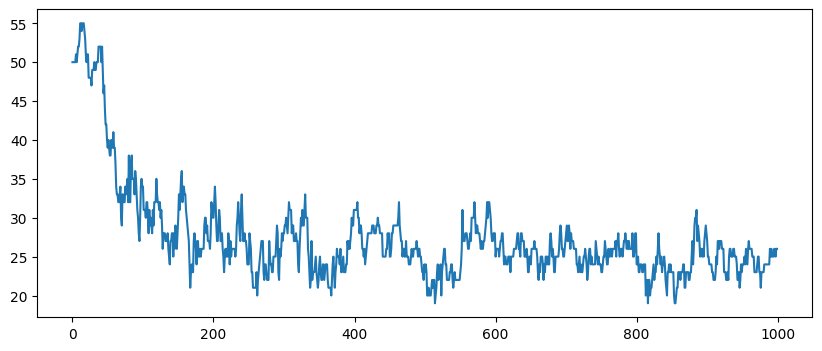

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(samples[7, 5, :1000, 1, 1])

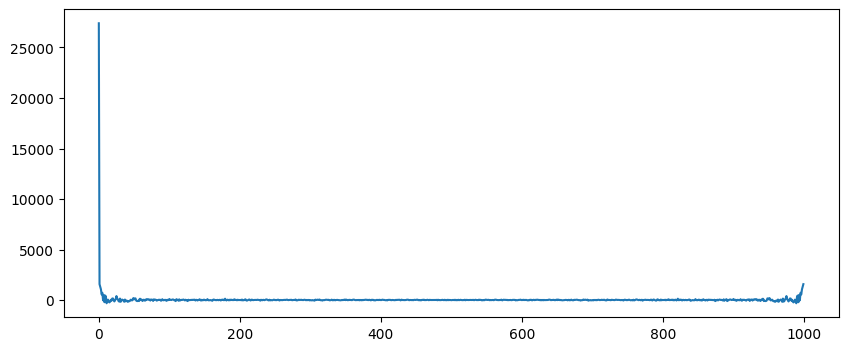

In [66]:
samples_ff = np.fft.fft(samples[7, 5, :1000, 1, 1])

plt.figure(figsize=(10, 4))
plt.plot(samples_ff.real)

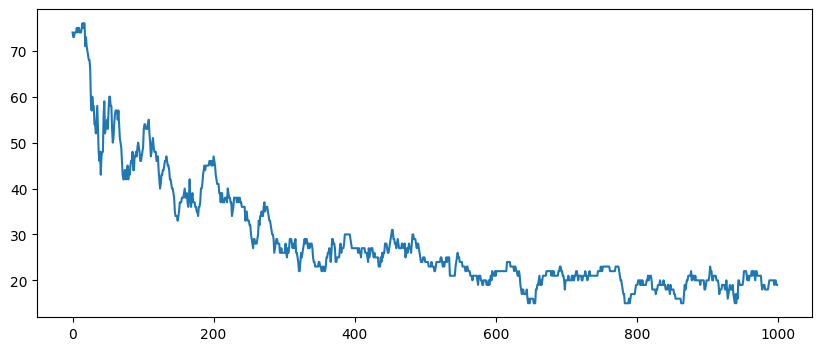

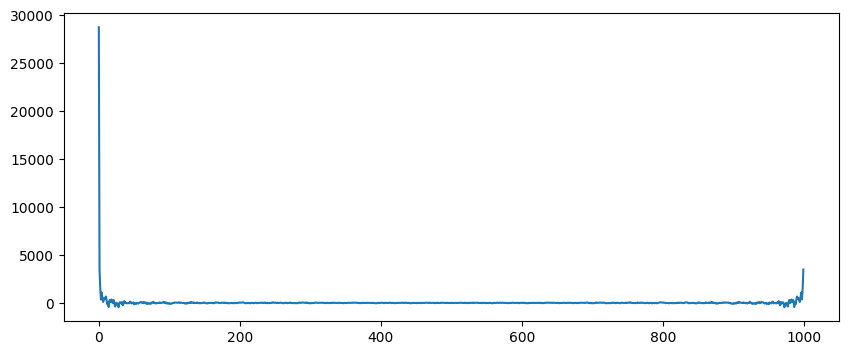

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(samples[10, 5, :1000, 1, 1])

samples_ff = np.fft.fft(samples[10, 5, :1000, 1, 1])

plt.figure(figsize=(10, 4))
plt.plot(samples_ff.real)

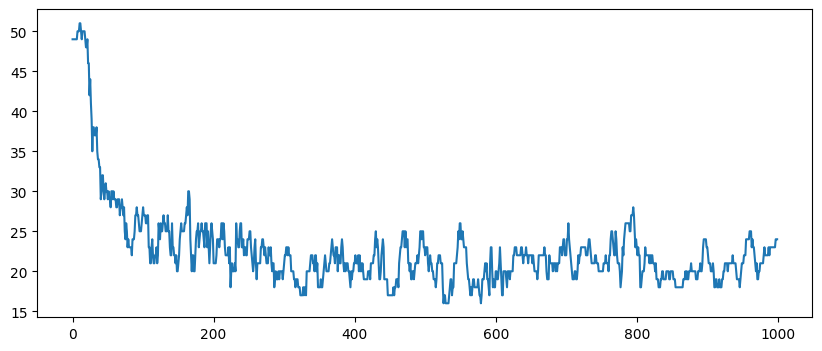

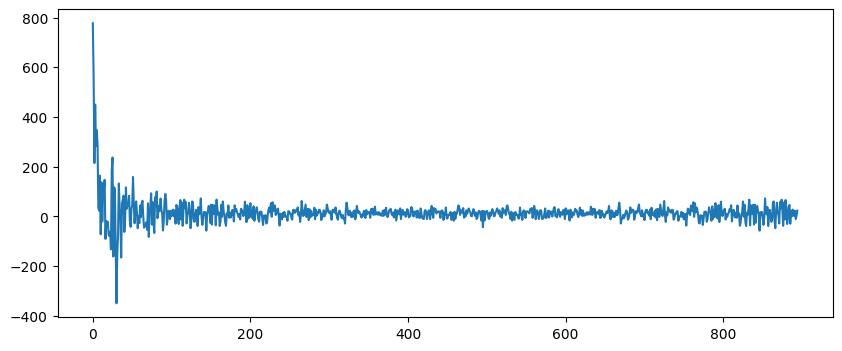

In [80]:
plt.figure(figsize=(10, 4))
plt.plot(samples[22, 80, :1000, 1, 1])

samples_ff = np.fft.fft(samples[22, 80, :1000, 1, 1])

plt.figure(figsize=(10, 4))
plt.plot(samples_ff.real[5:900])

## Real NVP

In [39]:
import jax.numpy as np
from jax import random

(-2.0, 2.0)

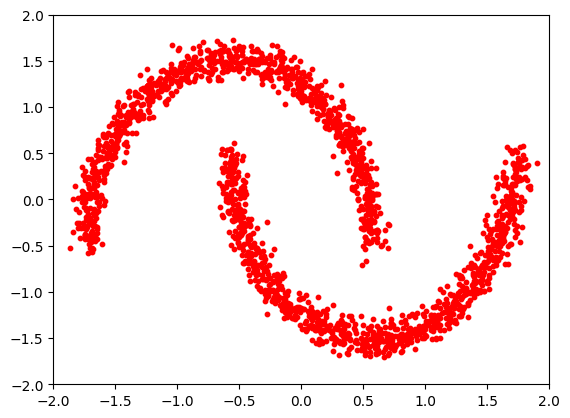

In [120]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [121]:
rng = random.PRNGKey(0)

In [148]:
def sample_n01(N):
  D = 16
  return random.normal(rng, (N, D))

def log_prob_n01(x):
  return jnp.sum(-jnp.square(x)/2 - jnp.log(jnp.sqrt(2*jnp.pi)),axis=-1)

(array([  8., 133., 506., 406., 147., 105.,  94., 104., 159., 338.]),
 array([-3.78112175, -3.59355922, -3.4059967 , -3.21843418, -3.03087166,
        -2.84330913, -2.65574661, -2.46818409, -2.28062157, -2.09305904,
        -1.90549652]),
 <BarContainer object of 10 artists>)

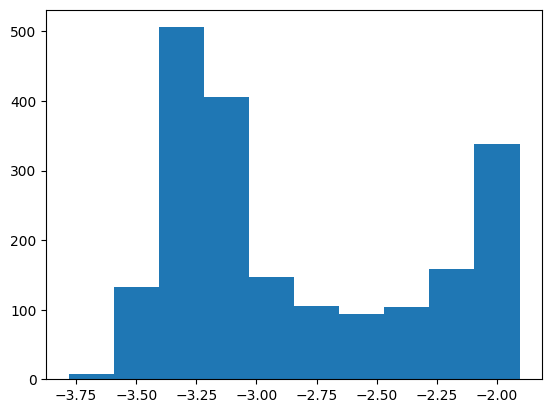

In [123]:
plt.hist(log_prob_n01(X))

In [124]:
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu # neural network layers

In [134]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
  d = x.shape[-1]//2
  x1, x2 = x[:, :d], x[:, d:]
  if flip:
    x2, x1 = x1, x2
  shift, log_scale = shift_and_log_scale_fn(net_params, x1)
  y2 = x2*np.exp(log_scale) + shift
  if flip:
    x1, y2 = y2, x1
  y = jnp.concatenate([x1, y2], axis=-1)
  return y

In [25]:
!pip install tensorflow-probability

In [136]:
import jax.numpy as jnp
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
  d = y.shape[-1]//2
  y1, y2 = y[:, :d], y[:, d:]
  if flip:
    y1, y2 = y2, y1
  shift, log_scale = shift_and_log_scale_fn(net_params, y1)
  x2 = (y2-shift)*jnp.exp(-log_scale)
  if flip:
    y1, x2 = x2, y1
  x = jnp.concatenate([y1, x2], axis=-1)
  return x, log_scale

In [147]:
def init_nvp():
  D = 16
  net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
  in_shape = (-1, D//2)
  out_shape, net_params = net_init(rng, in_shape)
  def shift_and_log_scale_fn(net_params, x1):
    s = net_apply(net_params, x1)
    return np.split(s, 2, axis=1)
  return net_params, shift_and_log_scale_fn

def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
  x = base_sample_fn(N)
  return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
  x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
  ildj = -np.sum(log_scale, axis=-1)
  return base_log_prob_fn(x) + ildj

In [128]:
def init_nvp_chain(n=2):
  flip = False
  ps, configs = [], []
  for i in range(n):
    p, f = init_nvp()
    ps.append(p), configs.append((f, flip))
    flip = not flip
  return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
  x = base_sample_fn(N)
  for p, config in zip(ps, configs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  return x

def make_log_prob_fn(p, log_prob_fn, config):
  shift_log_scale_fn, flip = config
  return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
  log_prob_fn = base_log_prob_fn
  for p, config in zip(ps, configs):
    log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
  return log_prob_fn(y)

In [129]:
ps, cs = init_nvp_chain(4)
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

(array([  4.,  30., 185., 348., 459., 161., 105., 119., 157., 432.]),
 array([-4.47447538, -4.20782423, -3.94117308, -3.67452192, -3.40787077,
        -3.14121962, -2.8745687 , -2.60791755, -2.34126639, -2.07461524,
        -1.80796409]),
 <BarContainer object of 10 artists>)

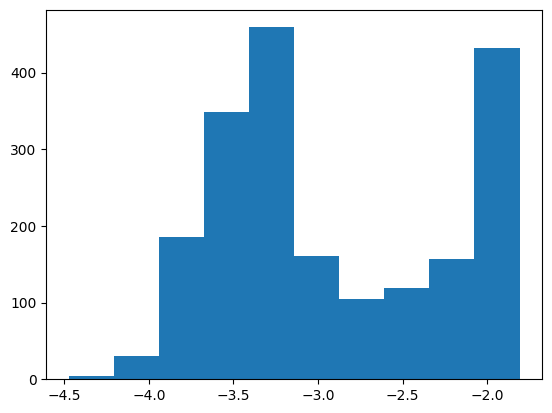

In [130]:
plt.hist(log_prob_nvp_chain(ps, cs, log_prob_n01, X))

In [159]:
from jax.example_libraries import optimizers
from jax import jit, grad
import numpy as np
from tqdm import tqdm

ps, cs = init_nvp_chain(4)

def loss(params, batch):
  return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  return opt_update(i, g, opt_state)

iters = int(100)


samples = samples.reshape(36, 100, 1000, 16)

# Let's take material 20 into account only
data_generator = (X_normalized[i,:,:] for i in range(iters))
 # (X[np.random.choice(X.shape[0], 100)] for _ in range(iters))
 #
opt_state = opt_init(ps)


for i in tqdm(range(iters)):
  opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


In [156]:
X = samples[20, :, :, :]

scaler = StandardScaler()

X_normalized = np.empty_like(X, dtype=np.float32)

# Loop over the second dimension (A)
for j in range(X.shape[0]):
    X_normalized[j, :, :] = scaler.fit_transform(X[j, :, :])

In [160]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

In [161]:
y

Array([[ 1.2534224 ,  1.293456  , -0.27496234, ...,  0.08823466,
         1.4135967 ,  1.7296773 ],
       [ 0.94604206,  0.08620852, -0.08936827, ..., -1.048486  ,
        -1.5876634 ,  0.5080095 ],
       [ 0.15362276, -0.2538289 , -0.7504522 , ..., -0.6646149 ,
        -0.39187723, -1.8222322 ],
       ...,
       [-0.6628753 ,  0.72264147, -1.4611069 , ...,  0.78812295,
         0.8582649 ,  2.1315637 ],
       [ 1.8062962 , -1.5290687 , -0.37733227, ..., -0.6677277 ,
        -1.5421971 ,  1.2599536 ],
       [-0.41154847,  0.6676641 , -1.9221314 , ...,  0.6607181 ,
         0.617039  ,  0.7620813 ]], dtype=float32)

In [54]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [142]:
x = sample_n01(1000)
values = [x]
for p, config in zip(ps, cs):
  shift_log_scale_fn, flip = config
  x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  values.append(x)

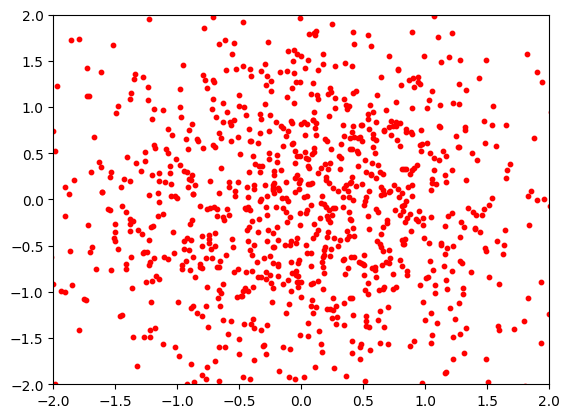

In [143]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, color='red')

In [144]:
def animate(i):
  l = i//48
  t = (float(i%48))/48
  y = (1-t)*values[l] + t*values[l+1]
  paths.set_offsets(y)
  return (paths,)

In [145]:
anim = animation.FuncAnimation(fig, animate, frames=48*len(cs), interval=1, blit=False)

In [146]:
anim.save('anim2.gif', writer='imagemagick', fps=60)

In [60]:
Image(url='anim2.gif')